# Reinforcement Learning Project

## Task 1

### **1a. Environment Setup**


In [1]:
import numpy as np
import random

class TrafficEnvironment:
    def __init__(self, lanes=5, initial_distance=4000):
        """
        Args:
        - lanes (int): Number of lanes (default is 5).
        - initial_distance (int): The distance from destination.
        """
        self.lanes = lanes
        self.initial_distance = initial_distance
        self.state = None
        self.rounding_precision = 1
        self.clearance_rate_min = 0
        # self.reset()

    def reset(self):
        # Initialize the state: distance from destination, current lane, and clearance rates for each lane
        # Initialize distance from destination to a random value within the provided range
        self.distance = self.initial_distance # Fixed initial distance
        self.current_lane = 1  # Always start from first lane
        # Initialize clearance rates randomly between 15 and 20 for all lanes
        self.clearance_rates = np.round(np.random.uniform(15, 20, size=self.lanes), self.rounding_precision)

        print('Initial Distance: ', self.distance)
        print('Initial Clearance Rates: ', self.clearance_rates)
        print('Initial Lane: ', self.current_lane)

        # Subtract the clearance rate of the current lane from the distance for the first state
        # self.distance -= self.clearance_rates[self.current_lane - 1]
        # self.distance = round(self.distance, self.rounding_precision)

        # Create an empty list to store state history (3 past states)
        self.state_history = [(self.distance, self.current_lane, *self.clearance_rates)]
        self.time_step = 0

        # Return the initial state
        return self.get_state()

    def get_state(self):
        # Return the most recent 3 states, if available, otherwise repeat initial state
        history_length = len(self.state_history)
        if history_length < 3:
            padding = [self.state_history[0]] * (3 - history_length)
            return padding + self.state_history
        else:
            return self.state_history[-3:]

    def step(self, action):
        """
        Takes an action (-1: move left, 0: stay, 1: move right), updates the state and returns:
        - Next state
        - Reward
        - Done (whether the episode is over)
        """
        reward = 0
        done = False

        # Handle lane change
        if action != 0:
            reward += self.attempt_lane_change(action)
        # No action needed for staying in the current lane

        # Update lane clearance rates based on neighboring lanes
        self.update_clearance_rates()

        # Compute the distance covered in the current lane
        clearance_rate = self.clearance_rates[self.current_lane - 1]
        distance_covered = clearance_rate
        self.distance -= distance_covered
        self.distance = round(self.distance, self.rounding_precision)

        # Time penalty
        reward += distance_covered - 10
        reward = round(reward, self.rounding_precision)

        # Now, after all the updates for the current time step, append the state to history
        self.state_history.append((self.distance, self.current_lane, *self.clearance_rates))

        # Check if the episode is done (if the destination is reached)
        if self.distance <= 0:
            done = True
            self.distance = 0

        # Return the new state (after applying the current time step's updates), reward, and done flag
        return self.get_state(), reward, done

    def attempt_lane_change(self, action):
        """
        Attempts to change lane based on the action.
        Args:
        - action (int): -1 for left, 1 for right.
        Returns:
        - penalty (float): The penalty to be applied to the reward.
        """
        penalty = -5  # Penalty for attempting a lane change

        # Check if the lane change is within bounds
        new_lane = self.current_lane + action
        if 1 <= new_lane <= self.lanes:
            # Attempt the lane change with a 50% success rate
            if random.random() < 0.5:
                self.current_lane = new_lane  # Lane change succeeds
        # If the lane change is invalid, the penalty is still applied

        return penalty

    def update_clearance_rates(self):
        # Update clearance rates based on adjacent lanes' speeds and add uncertainty term N(0, 0.1)
        updated_rates = self.clearance_rates.copy()
        for i in range(self.lanes):
            # Adding the uncertainty term N(0, 0.1)
            uncertainty = np.random.normal(0, 0.1)

            # Random Event: 5% chance of slowdown (20%-50%) and 5% chance of speedup (20%-40%)
            random_event = random.random()
            # 5% chance of slowdown
            if random_event < 0.05:
                updated_rates[i] -= self.clearance_rates[i] * random.uniform(0.2, 0.5)
            # 5% chance of speedup
            elif random_event >= 0.05 and random_event < 0.1:
                updated_rates[i] += self.clearance_rates[i] * random.uniform(0.2, 0.4)

            # Update based on adjacent lanes, with sgn function and uncertainty
            if i > 0:
                updated_rates[i] += 0.2 * np.sign(self.clearance_rates[i - 1] - self.clearance_rates[i])
            if i < self.lanes - 1:
                updated_rates[i] += 0.2 * np.sign(self.clearance_rates[i + 1] - self.clearance_rates[i])

            # Apply the uncertainty term to each lane
            updated_rates[i] += uncertainty

            # Round clearance rates to 4 significant digits
            updated_rates[i] = round(updated_rates[i], self.rounding_precision)

            # Ensure clearance rates don't drop below a minimum threshold
            updated_rates[i] = max(updated_rates[i], self.clearance_rate_min)

        self.clearance_rates = updated_rates

In [2]:
import matplotlib.pyplot as plt

# Example usage:
env = TrafficEnvironment()
state = env.reset()
done = False
rewards = []  # To track rewards at each time step
time_steps = []  # To track the time step number

time_step_counter = 0

while not done:
    # Randomly choose an action (-1: move left, 0: stay, 1: move right)
    action = random.choice([-1, 0, 1])

    # Take the step
    next_state, reward, done = env.step(action)

    # Append the reward for this time step
    rewards.append(reward)
    time_steps.append(time_step_counter)

    # Increment the time step counter
    time_step_counter += 1

    print(f"Action: {action}, Reward: {reward}, Done: {done}")
    print(f"Next State: {next_state}")

Initial Distance:  3821.9
Initial Clearance Rates:  [17.1 18.2 18.8 15.7 17.9]
Initial Lane:  3
Action: 0, Reward: 8.3, Done: False
Next State: [(3821.9, 3, 17.1, 18.2, 18.8, 15.7, 17.9), (3821.9, 3, 17.1, 18.2, 18.8, 15.7, 17.9), (3803.6, 3, 17.2, 18.1, 18.3, 16.2, 17.7)]
Action: 0, Reward: 7.9, Done: False
Next State: [(3821.9, 3, 17.1, 18.2, 18.8, 15.7, 17.9), (3803.6, 3, 17.2, 18.1, 18.3, 16.2, 17.7), (3785.7, 3, 17.4, 18.1, 17.9, 16.5, 17.5)]
Action: 1, Reward: 3.0, Done: False
Next State: [(3803.6, 3, 17.2, 18.1, 18.3, 16.2, 17.7), (3785.7, 3, 17.4, 18.1, 17.9, 16.5, 17.5), (3767.7, 3, 17.7, 17.7, 18.0, 16.8, 17.6)]
Action: -1, Reward: 2.6, Done: False
Next State: [(3785.7, 3, 17.4, 18.1, 17.9, 16.5, 17.5), (3767.7, 3, 17.7, 17.7, 18.0, 16.8, 17.6), (3750.1, 3, 17.9, 23.3, 17.6, 17.1, 17.5)]
Action: 0, Reward: 7.6, Done: False
Next State: [(3767.7, 3, 17.7, 17.7, 18.0, 16.8, 17.6), (3750.1, 3, 17.9, 23.3, 17.6, 17.1, 17.5), (3732.5, 3, 18.2, 23.0, 17.6, 17.4, 17.3)]
Action: 0, Re

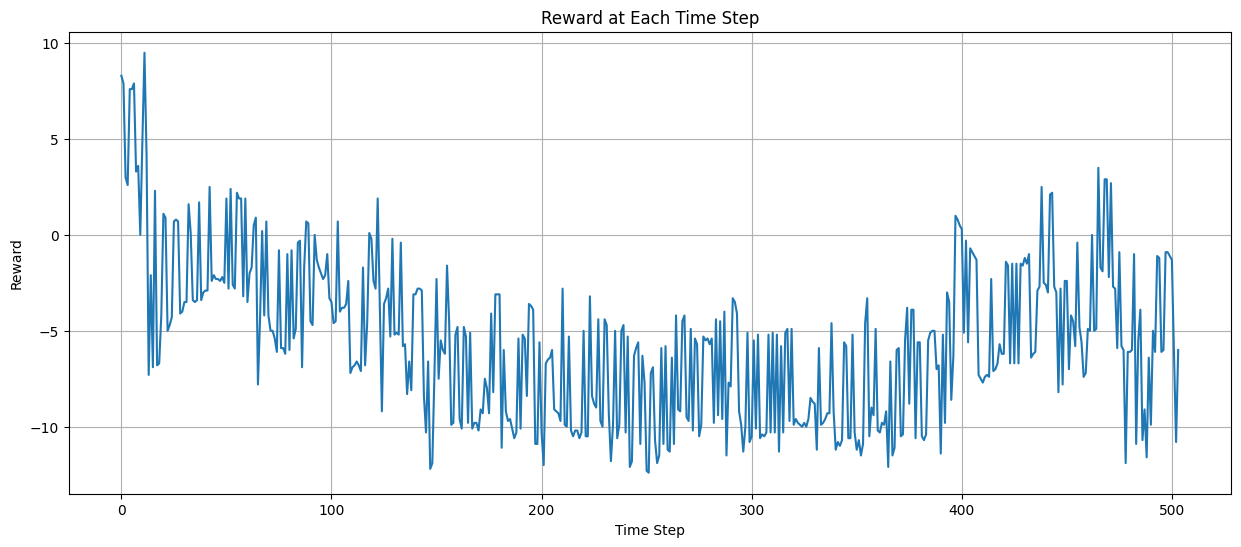

In [3]:
# Plot the rewards over time
plt.figure(figsize=(15, 6))
plt.plot(time_steps, rewards)
plt.title('Reward at Each Time Step')
plt.xlabel('Time Step')
plt.ylabel('Reward')
plt.grid(True)
plt.show()